In [ ]:
!pip install numpy
!pip install pandas

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import avg, round

In [4]:
import pyspark as ps
from pyspark.sql.functions import count, avg,max,min
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [5]:
spark_session = SparkSession.builder\
 .enableHiveSupport()\
 .appName("IOWA Sales")\
 .master("local")\
 .getOrCreate()

In [6]:
df = spark_session.read.csv('Iowa_10_percent.csv')

In [7]:
df = spark_session.read.option('header','true').csv('Iowa_10_percent.csv',inferSchema=True)

In [8]:
df.printSchema()

root
 |-- Invoice/Item Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Store Number: integer (nullable = true)
 |-- Store Name: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zip Code: string (nullable = true)
 |-- Store Location: string (nullable = true)
 |-- County Number: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Category: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Vendor Number: integer (nullable = true)
 |-- Vendor Name: string (nullable = true)
 |-- Item Number: string (nullable = true)
 |-- Item Description: string (nullable = true)
 |-- Pack: integer (nullable = true)
 |-- Bottle Volume (ml): integer (nullable = true)
 |-- State Bottle Cost: double (nullable = true)
 |-- State Bottle Retail: double (nullable = true)
 |-- Bottles Sold: integer (nullable = true)
 |-- Sale (Dollars): double (nullable = true)
 |-- Volume Sold (Liters): doub

In [9]:
%%time
# Convert timestamp str to timestamp
df = df.withColumn('Date',to_date("Date","MM/dd/yyy"))

# Convert City Names
df = df.withColumn('City',upper("City"))

# Create new column for year 
df = df.withColumn('Year', year(col('Date')))

# Create new column for month 
df = df.withColumn('Month', month(col('Date')))

# Brand names
df = df.withColumn('Category Name',upper("Category Name"))

# Drop na values where year is NA
# drop None Values
df.na.drop(subset=["Year","County"])

Wall time: 335 ms


In [10]:
%%time
# Count County ( Clean the County name data to remove duplicates due to Uppercase / Lowercase mismatches.)
df = df.withColumn('County',upper("County"))

Wall time: 30.5 ms


### Here we can see that we have data from 2012 to 2020. 

In [11]:
%%time
years = df.select("Year").distinct().sort("Year").show()

+----+
|Year|
+----+
|2012|
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
|2019|
|2020|
+----+

Wall time: 14.1 s


## Q1: Total sales for each county and city.
We list the top 10 County and City in terms of sales. 
By this question, we find out which county consumes the most alcohol.

In [12]:
%%time
# Select most popular brand here
df_1 = df.groupBy('County').sum('Sale (Dollars)').alias('Sales')

Wall time: 71.7 ms


In [13]:
%%time
df_1.sort(col("sum(Sale (Dollars))")).show()

+----------+-------------------+
|    County|sum(Sale (Dollars))|
+----------+-------------------+
|   FREMONT| 27555.220000000005|
|     ADAMS|  87996.81999999999|
|     DAVIS|           99683.76|
|    TAYLOR|          106213.88|
|     WAYNE|           106503.0|
|  RINGGOLD| 122793.09999999999|
|   AUDUBON| 145344.55000000002|
|    KEOKUK|          150451.65|
|   DECATUR| 157740.01000000007|
| VAN BUREN| 162379.94999999995|
|    LOUISA| 210894.84000000023|
|   OSCEOLA|  226278.5500000001|
|     WORTH| 229507.62999999995|
|    BUTLER|          264441.69|
|    GRUNDY|          267198.29|
|   GUTHRIE|  286699.6800000003|
|    MONROE|  305257.5900000001|
|POCAHONTAS| 307460.00000000006|
|   CALHOUN| 312247.51999999984|
|   HANCOCK| 324731.86000000016|
+----------+-------------------+
only showing top 20 rows

Wall time: 11.2 s


### City

In [14]:
%%time
df_2 = df.groupBy('City').sum('Bottles Sold').alias('Sales')

Wall time: 36.9 ms


In [15]:
%%time
df_2.sort("sum(Bottles Sold)").show()

+---------------+-----------------+
|           City|sum(Bottles Sold)|
+---------------+-----------------+
|         ALVORD|                1|
|       ALLERTON|               28|
|         MURRAY|               40|
|        CHESTER|               66|
|    MORNING SUN|               89|
|           RUDD|               90|
|         WASHTA|               95|
|        WYOMING|              155|
|   LIME SPRINGS|              164|
|       MARTELLE|              175|
|      APLINGTON|              214|
|         CALMAR|              257|
|         LAMONT|              259|
|PLEASANT VALLEY|              291|
|     ALTA VISTA|              292|
|     GARNAVILLO|              309|
|        POMEROY|              314|
|        MAYNARD|              315|
|         HINTON|              320|
|      VAN HORNE|              332|
+---------------+-----------------+
only showing top 20 rows

Wall time: 12.5 s


## Q2 : How many brands are there total ? 

There are total 110 brands/categories in the dataset. 

In [16]:
%%time
brands_df=df.select(countDistinct("Category Name")).show()

+-----------------------------+
|count(DISTINCT Category Name)|
+-----------------------------+
|                          108|
+-----------------------------+

Wall time: 11.4 s


# Q3: Which brands are the most sold / famous. 
In this section we find out the brands which are most famous of all time and then for every year and every month.
<br>

Write about the trend that we can observe here as the bottles sold for every product changed over years.

In [ ]:
# Most famous brands of all time

In [17]:
%%time 
df_brands = df.groupBy("Category Name").agg({"Bottles Sold": "sum","Sale (Dollars)": "sum"})

Wall time: 37.9 ms


### The best 10 sold liquor of all time.

In [18]:
%%time
#Now we sort them on the basis of sales
df_brands.sort(col("sum(Bottles Sold)").desc()).show(10)

+--------------------+--------------------+-----------------+
|       Category Name| sum(Sale (Dollars))|sum(Bottles Sold)|
+--------------------+--------------------+-----------------+
|   CANADIAN WHISKIES|3.1663907610001802E7|          2257037|
|     AMERICAN VODKAS|2.0184462489997026E7|          2223027|
|      VODKA 80 PROOF|1.4500635470000194E7|          1808625|
|          SPICED RUM|1.9199091930000298E7|          1259547|
|     WHISKEY LIQUEUR| 1.272747751000017E7|          1244542|
|STRAIGHT BOURBON ...| 1.573435572999996E7|           882774|
|    BLENDED WHISKIES|   7544631.899999948|           780877|
|  TENNESSEE WHISKIES|1.1433202540000392E7|           512248|
|   AMERICAN DRY GINS|  3110570.7599999886|           426990|
|        FLAVORED RUM|   5587746.609999534|           422501|
+--------------------+--------------------+-----------------+
only showing top 10 rows

Wall time: 11.3 s


### Most famous brands every year 

In [19]:
%%time
df_brands = df.groupBy("Year","Category Name") \
    .sum("Bottles Sold")

Wall time: 36.7 ms


In [20]:
%%time
df_brands = df_brands.groupBy("Year","Category Name").agg({"sum(Bottles Sold)":"max"})

Wall time: 17 ms


In [21]:
%%time
years = [year for year in range(2012,2021)]
for year in years:
    df_brands.where(f'Year == {year}').sort(col("max(sum(Bottles Sold))").desc()).show(3)

+----+-----------------+----------------------+
|Year|    Category Name|max(sum(Bottles Sold))|
+----+-----------------+----------------------+
|2012|   VODKA 80 PROOF|                343220|
|2012|CANADIAN WHISKIES|                208404|
|2012|       SPICED RUM|                137653|
+----+-----------------+----------------------+
only showing top 3 rows

+----+-----------------+----------------------+
|Year|    Category Name|max(sum(Bottles Sold))|
+----+-----------------+----------------------+
|2013|   VODKA 80 PROOF|                357737|
|2013|CANADIAN WHISKIES|                226776|
|2013|       SPICED RUM|                154644|
+----+-----------------+----------------------+
only showing top 3 rows

+----+-----------------+----------------------+
|Year|    Category Name|max(sum(Bottles Sold))|
+----+-----------------+----------------------+
|2014|   VODKA 80 PROOF|                393319|
|2014|CANADIAN WHISKIES|                240918|
|2014|       SPICED RUM|              

## Q4: What are the various packaging types and which type of packaging was sold the most ? For example, 750 ml or 100ml etc. 


In [22]:
%%time
# List out the different packaging types available.
df_volume = df.groupby("Bottle Volume (ml)").agg({"Sale (Dollars)": "sum"})

Wall time: 22.7 ms


In [23]:
%%time
# Which one is the most famous one
df_volume.sort(col("sum(Sale (Dollars))").desc()).show(5)

+------------------+--------------------+
|Bottle Volume (ml)| sum(Sale (Dollars))|
+------------------+--------------------+
|               750|1.0694217439999333E8|
|              1750| 6.737514133000413E7|
|              1000| 6.077287644000481E7|
|               375|1.4879685469999421E7|
|               200|   5701155.400000061|
+------------------+--------------------+
only showing top 5 rows

Wall time: 8.14 s


In [24]:
%%time
# Which packaging is the least preferred one.
df_volume.sort(col("sum(Sale (Dollars))").asc()).show(5)

+------------------+-------------------+
|Bottle Volume (ml)|sum(Sale (Dollars))|
+------------------+-------------------+
|               355|               45.0|
|              1420|               99.0|
|              2550|             275.92|
|              2000| 320.15999999999997|
|              4500|             413.64|
+------------------+-------------------+
only showing top 5 rows

Wall time: 8.09 s


In [26]:
#For Example Consider this sample. As it is clear, CANADIAN WHISKIES of the same volume (1000 ml) has different prices in different zones
converted_df=df
converted_df.select('Category Name','State Bottle Cost','Zip Code','Bottle Volume (ml)','State Bottle Retail').filter((F.col('Category Name')=='CANADIAN WHISKIES')).show()

+-----------------+-----------------+--------+------------------+-------------------+
|    Category Name|State Bottle Cost|Zip Code|Bottle Volume (ml)|State Bottle Retail|
+-----------------+-----------------+--------+------------------+-------------------+
|CANADIAN WHISKIES|             7.36|   50317|               375|              11.04|
|CANADIAN WHISKIES|              4.2|   50129|               750|                6.3|
|CANADIAN WHISKIES|             9.99|   52060|              1000|              14.99|
|CANADIAN WHISKIES|             9.97|   52401|               750|              14.96|
|CANADIAN WHISKIES|             3.07|   50170|               375|               4.61|
|CANADIAN WHISKIES|             2.05|   50315|               375|               3.08|
|CANADIAN WHISKIES|            18.89|    null|              1000|              28.34|
|CANADIAN WHISKIES|             9.71|   52301|              1000|              14.57|
|CANADIAN WHISKIES|            15.59|    null|        

## Q5:

In [27]:
#convert the features to float:
converted_df=df.withColumn('State Bottle Retail',df['State Bottle Retail'].cast("float").alias('State Bottle Retail'))

converted_df=converted_df.withColumn('State Bottle Cost',converted_df['State Bottle Cost'].cast("float").alias('State Bottle Cost'))
converted_df=converted_df.withColumn('Zip Code',converted_df['Zip Code'].cast("float").alias('Zip Code'))
converted_df=converted_df.withColumn('Bottle Volume (ml)',converted_df['Bottle Volume (ml)'].cast("float").alias('Bottle Volume (ml)'))

In [ ]:
%%time
#Training dataset and its visulazition:
training_df=np.array(converted_df.select('State Bottle Cost','Zip Code','Bottle Volume (ml)','Sale (Dollars)','State Bottle Retail').dropna().collect())

training_npset=np.array(training_df).astype(float)



fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(training_npset[0:10000,0], training_npset[0:10000,1], training_npset[:,2])
ax.set_xlabel('Price')
ax.set_ylabel('Zip Code')
ax.set_zlabel('Volume(ml)')


plt.show()

In [29]:

#Correlation between Price and Bottle Volume:

cr_vol=np.corrcoef(training_npset[:,0], training_npset[:,2])
print(cr_vol[0][1])

0.4804221830300319


In [30]:
#Correlation between Price and zip code are:
cr_zip=np.corrcoef(training_npset[:,0], training_npset[:,1])
print(cr_zip[0][1])

-0.014209971982009573


In [31]:
#Correlation between Price and Sale:
cr_zip=np.corrcoef(training_npset[:,0], training_npset[:,3])
print(cr_zip[0][1])

0.10317526664216911


In [32]:
#Correlation between Price and State Bottle Retail:
cr_zip=np.corrcoef(training_npset[:,0], training_npset[:,4])
print(cr_zip[0][1])

0.999980868867957


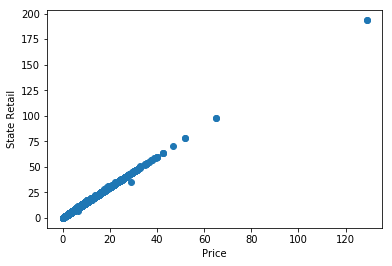

In [33]:
#Best choise is State retail for prediction. As it is clear from the Figure below:
plt.scatter(training_npset[0:10000,0],training_npset[0:10000,4])
plt.xlabel('Price')
plt.ylabel('State Retail')
plt.show()

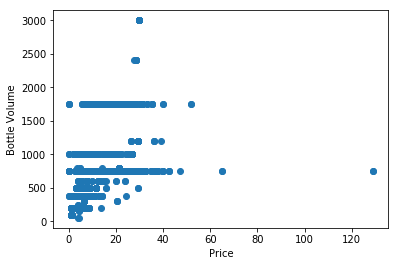

In [34]:
#Plot to see how Bottle Volume and Price are correlated:
plt.scatter(training_npset[0:10000,0],training_npset[0:10000,2])
plt.xlabel('Price')
plt.ylabel('Bottle Volume')
plt.show()

### As it is clear from the figure above and the amount of correlations, State Retail and Bottle Volume are a good features to use in linear regression

In [35]:
training_df=converted_df.select('State Bottle Cost','State Bottle Retail','Bottle Volume (ml)').dropna()
assembler = VectorAssembler().setInputCols(['State Bottle Retail','Bottle Volume (ml)']).setOutputCol('features')
tr_df=assembler.transform(training_df)

In [36]:
tr_df.show(5)

+-----------------+-------------------+------------------+--------------------+
|State Bottle Cost|State Bottle Retail|Bottle Volume (ml)|            features|
+-----------------+-------------------+------------------+--------------------+
|              0.0|                0.0|             750.0|         [0.0,750.0]|
|             0.97|               1.46|             100.0|[1.46000003814697...|
|             7.36|              11.04|             375.0|[11.0399999618530...|
|            11.49|              17.24|             750.0|[17.2399997711181...|
|             4.75|               7.13|             750.0|[7.13000011444091...|
+-----------------+-------------------+------------------+--------------------+
only showing top 5 rows



In [37]:
final_df= tr_df.select(['features', F.col('State Bottle Cost').alias('label')])
final_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|         [0.0,750.0]|  0.0|
|[1.46000003814697...| 0.97|
|[11.0399999618530...| 7.36|
|[17.2399997711181...|11.49|
|[7.13000011444091...| 4.75|
+--------------------+-----+
only showing top 5 rows



In [38]:
#Train and test split:
train, test = final_df.randomSplit([0.7, 0.3], seed=42)

In [39]:
lr_model = LinearRegression(featuresCol='features',labelCol='label')


In [41]:
%%time
fit_model = lr_model.fit(train)


Wall time: 44.2 s


In [42]:
%%time
test_results = fit_model.evaluate(test)
print(test_results.r2*100,' percent accuracy on test set')


99.99664548085066  percent accuracy on test set
Wall time: 24.3 s


In [43]:
y_pred=np.array(test_results.predictions.select("prediction").collect())

In [46]:
test_np=np.array(test.select('features').collect())
y_true=np.array(test.select('label').collect())


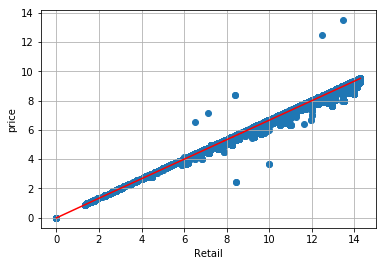

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()

n=100000

plt.scatter(test_np[0:n,0][0:n,0],y_true[0:n,0] )
plt.xlabel("Retail")
plt.ylabel('price')
plt.plot(test_np[0:n,0][0:n,0], y_pred[0:n,0],  c='r')

plt.show()